*   Trennen von ED und ERGO
*   Cluster



In [1]:
%matplotlib inline

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from google.colab import drive

class GC:
    PROJECT_ROOT_DIR = '/content/drive/MyDrive/workspaces/GEAR'
    DATA_DIR = os.path.join(PROJECT_ROOT_DIR, 'data')
    OUTPUT_DIR = os.path.join(PROJECT_ROOT_DIR, 'output')
    TB_LOG_DIR= os.path.join(OUTPUT_DIR, 'tb-logs')
    SRC_DIR = os.path.join(PROJECT_ROOT_DIR, 'src')

drive.mount('/content/drive')

Mounted at /content/drive


In [173]:
data = pd.ExcelFile(os.path.join(GC.DATA_DIR, 'GEAR_Export_20220106_093424.xlsx'))

df_application = data.parse('Application')[['name']]
df_application.rename(columns={'name':'NAME'}, inplace=True)
df_application.dropna(inplace=True)
df_application.set_index('NAME', inplace=True)
df_application.drop('Name', inplace=True)
df_application['NR'] = np.arange(len(df_application)) + 1

df_interface_provider = data.parse('applicationInterfaceProviderRe')
df_interface_provider.drop(['id', 'type', 'RELATED_FACT_SHEET_TYPE', 'RELATED_FACT_SHEET_TYPE.1', 'status', 'activeFrom', 'activeUntil', 'naFields', 'description'], axis=1, inplace=True)
df_interface_provider.rename(columns = {'RELATED_FACT_SHEET':'PROVIDER_APPLICATION', 'RELATED_FACT_SHEET.1':'INTERFACE'}, inplace = True)
df_interface_provider.dropna(inplace = True)
df_interface_provider.set_index('INTERFACE', inplace = True)
df_interface_provider.drop('To', inplace = True)

df_interface_consumer = data.parse('applicationInterfaceConsumerRe')
df_interface_consumer.drop(['id', 'type', 'RELATED_FACT_SHEET_TYPE', 'RELATED_FACT_SHEET_TYPE.1', 'status', 'activeFrom', 'activeUntil', 'naFields', 'description'], axis=1, inplace=True)
df_interface_consumer.rename(columns = {'RELATED_FACT_SHEET':'CONSUMER_APPLICATION', 'RELATED_FACT_SHEET.1':'INTERFACE'}, inplace = True)
df_interface_consumer.dropna(inplace = True)
df_interface_consumer.set_index('INTERFACE', inplace = True)
df_interface_consumer.drop('To', inplace = True)

df_edges = df_interface_provider.join(df_interface_consumer)
df_edges.reset_index(drop=False, inplace=True)
df_edges.set_index('PROVIDER_APPLICATION', inplace = True)

#df_vertices = df_application.reset_index(drop=False, inplace=False)
#df_vertices = df_vertices[['NR', 'NAME']]

df_edges = df_edges.join(df_application)
df_edges.reset_index(drop=False, inplace=True)
#df_edges.set_index('CONSUMER_APPLICATION', inplace = True)
#df_edges.rename(columns={'NR':'PROVIDER_NR', 'index':'PROVIDER_APPLICATION'}, inplace=True)

#df_edges = df_edges.join(df_application)
df_edges

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,index,INTERFACE,CONSUMER_APPLICATION,NR
0,AD-DB,AD-DB | Allgemeine Vertragsdaten,Allgemeine Vertragsdaten,11
1,AD-DB,AD-DB | ZKK Konto,ZKK Konto,11
2,AD-DB,AD-DB | Zulagensystem (AZUR),Zulagensystem (AZUR),11
3,AD-DB,AD-DB | iLiFE (Life-Factory),iLiFE (Life-Factory),11
4,AD-DB,AD-DB | Komposit Leistungsbearbeitung (SaViR),Komposit Leistungsbearbeitung (SaViR),11
...,...,...,...,...
3090,zentrale Geldeingangsverarbeitung CCM inklusiv...,zentrale Geldeingangsverarbeitung CCM inklusiv...,ZKK-Partnerinkasso,301
3091,zentrale Geldeingangsverarbeitung CCM inklusiv...,zentrale Geldeingangsverarbeitung CCM inklusiv...,Leben Verwaltung Antrag/Vertrag,301
3092,zentrale Geldeingangsverarbeitung CCM inklusiv...,zentrale Geldeingangsverarbeitung CCM inklusiv...,Life Classic Integration,301
3093,zentrale Geldeingangsverarbeitung CCM inklusiv...,zentrale Geldeingangsverarbeitung CCM inklusiv...,ZKK-Leistungskontokorrent,301


In [144]:
graph = nx.DiGraph()

for s1 in df_vertices.values:
    graph.add_node(s1[0])

for s1, s2, s3 in df_edges.values:
    graph.add_edge(s3, s2, name=s1)

in_degrees = sorted(graph.in_degree(), key = lambda x: x[1], reverse=True)
in_degree_values = [x[1] for x in list(in_degrees)]
in_degree_counts = {x:in_degree_values.count(x) for x in in_degree_values}

print(graph.number_of_nodes(), graph.number_of_edges())
print(in_degrees[:10])
print(in_degree_values[:10])
print(in_degree_counts)

653 3095
[('DiOrg Aufbauorganisation', 113), ('ERGO-Partnersystem (PDB)', 111), ('Allgemeine Vertragsdaten', 107), ('ERGO Berechtigungssystem', 91), ('Vorgangs-DB (incl. AVuS)', 72), ('Leben Verwaltung Antrag/Vertrag', 66), ('Komposit Vertragsverwaltung (SV)', 66), ('SAP-HCM Personalwirtschaft', 65), ('ZKK Allgemein', 59), ('Gesundheit Bestandsverwaltung', 58)]
[113, 111, 107, 91, 72, 66, 66, 65, 59, 58]
{113: 1, 111: 1, 107: 1, 91: 1, 72: 1, 66: 2, 65: 1, 59: 1, 58: 1, 55: 1, 48: 1, 43: 1, 41: 2, 40: 2, 39: 1, 38: 1, 37: 1, 36: 2, 35: 1, 33: 2, 32: 2, 30: 2, 29: 1, 28: 1, 27: 1, 26: 1, 24: 1, 23: 1, 22: 4, 21: 1, 20: 5, 19: 4, 18: 4, 17: 2, 16: 6, 15: 4, 14: 5, 13: 4, 12: 7, 11: 3, 10: 5, 9: 6, 8: 7, 7: 9, 6: 15, 5: 12, 4: 12, 3: 17, 2: 37, 1: 79, 0: 370}


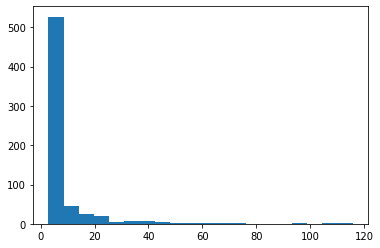

In [145]:
plt.hist(in_degree_values, bins=20, align='right', log=False)
plt.show()

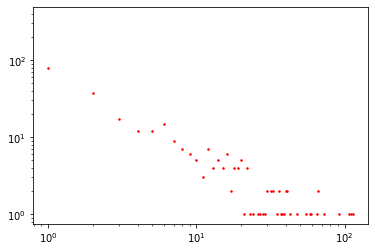

In [146]:
plt.plot(list(in_degree_counts.keys()), list(in_degree_counts.values()), 'r.', markersize=3)
plt.semilogx()
plt.semilogy()
plt.show()
#2 diagrams

In [147]:
sorted(nx.eigenvector_centrality(graph).items(), key=lambda x : x[1], reverse=True)[:10]

[('ERGO-Partnersystem (PDB)', 0.2709977837095329),
 ('Allgemeine Vertragsdaten', 0.26027199899085673),
 ('ERGO Berechtigungssystem', 0.2567929694274976),
 ('DiOrg Aufbauorganisation', 0.24892384526243988),
 ('Komposit Vertragsverwaltung (SV)', 0.21603441763367773),
 ('Vorgangs-DB (incl. AVuS)', 0.2114026663358469),
 ('Code of Conduct', 0.2076353297300809),
 ('Leben Verwaltung Antrag/Vertrag', 0.1779593528419094),
 ('SAP-HCM Personalwirtschaft', 0.17714621061046773),
 ('ZKK Allgemein', 0.1744061046251806)]

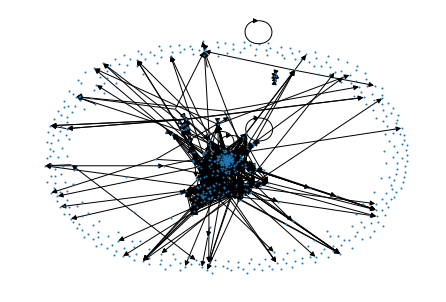

In [150]:
nx.draw(graph, node_size=1)

In [149]:
list(nx.selfloop_edges(graph))

[('Gesundheit Vertragsverwaltung Ausland',
  'Gesundheit Vertragsverwaltung Ausland'),
 ('TDM2000', 'TDM2000'),
 ('Igloo Enterprise', 'Igloo Enterprise'),
 ('Dispositives System Gesundheit/Datamarts Kalkulation (DMK)',
  'Dispositives System Gesundheit/Datamarts Kalkulation (DMK)')]

In [155]:
G = nx.karate_club_graph()
sorted(nx.eigenvector_centrality(G).items(), key=lambda x : x[1], reverse=True)[:10]

[(33, 0.373371213013235),
 (0, 0.3554834941851943),
 (2, 0.31718938996844476),
 (32, 0.3086510477336959),
 (1, 0.2659538704545025),
 (8, 0.2274050914716605),
 (13, 0.22646969838808148),
 (3, 0.2111740783205706),
 (31, 0.19103626979791702),
 (30, 0.17476027834493085)]